In [166]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from pathlib import Path
import datetime as dtm

from algorithms.power_integration import integrate_control_scheme, integrate_sun_diagram
from device_sun_position import sun_position
from models.directional_diagram import DirectionalDiagram

from models.position_correction import PositionCorrection

import motor_specs
from correction_strategy_selection import get_sun_borders, get_total_motor_consumption
from models.control_scheme import ControlScheme

plt.style.use("dark_background")

In [167]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
data_folder = Path("../data")
data_paths = sorted(list(data_folder.glob("*.csv")))
data_paths

[PosixPath('../data/clouds1.csv'),
 PosixPath('../data/stationary_strategy_total.csv'),
 PosixPath('../data/statistics_11-29-28-161253D29-05-2022.csv'),
 PosixPath('../data/statistics_11-57-40-599734D29-05-2022.csv'),
 PosixPath('../data/statistics_12-06-56-142868D29-05-2022.csv')]

In [187]:
data_path = data_paths[0]
data = pd.read_csv(data_path)
data.head()

time  azimuth  altitude   voltage     power
0  1.653060e+09      180         0  0.058594  0.000042
1  1.653060e+09      180         0  0.048828  0.000029
2  1.653060e+09      180         0  0.048828  0.000029
3  1.653060e+09      180         0  0.048828  0.000029
4  1.653060e+09      180         0  0.048828  0.000029

In [188]:
from models.sun_power_diagram import SunPowerDiagram

sun_diagram = SunPowerDiagram.from_table(data, 5)
dir_diagram = sun_diagram.diagram

In [189]:
(max_az, max_al), value = dir_diagram.get_max_position()
max_az, max_al, value

(280.0, 35.0, 0.0013842815306128)

In [190]:
100 * 0.0013842 / 0.26351

0.5252931577549238

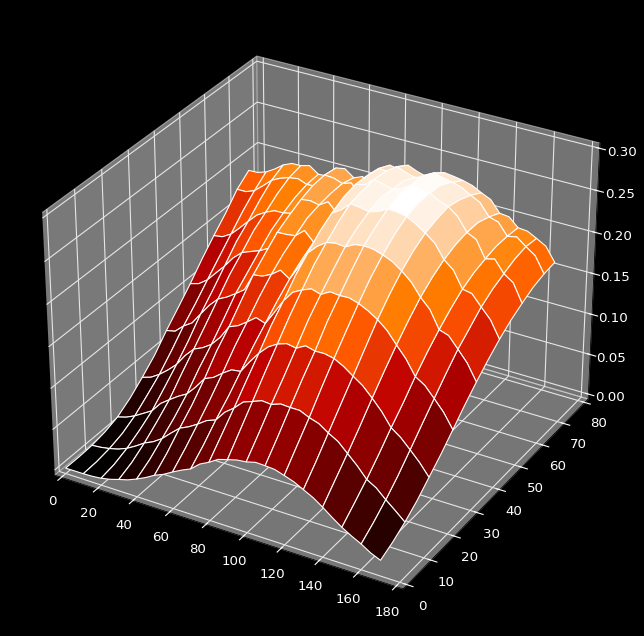

In [182]:
fig = plt.figure()
fig.set_size_inches(10, 10)
ax = fig.add_subplot(111, projection='3d')

az_v, al_v = np.meshgrid(list(dir_diagram.az_range), list(dir_diagram.al_range))
_points = np.concatenate((np.atleast_2d(az_v.flatten()),
                         np.atleast_2d(al_v.flatten())), axis=0)
values = dir_diagram.get_power(_points).reshape(az_v.shape)
_stride = 2
ax.plot_surface(az_v, al_v, values, cmap=mpl.cm.gist_heat, cstride=_stride, rstride=_stride)

In [183]:
max_pos = np.unravel_index(np.argmax(values, axis=None), values.shape)
az_v[max_pos], al_v[max_pos], values[max_pos]

(110, 55, 0.2635137046255716)

In [184]:
expected_max = sun_position(sun_diagram.time)
expected_max

(array([157.18283942]), array([58.70446769]))

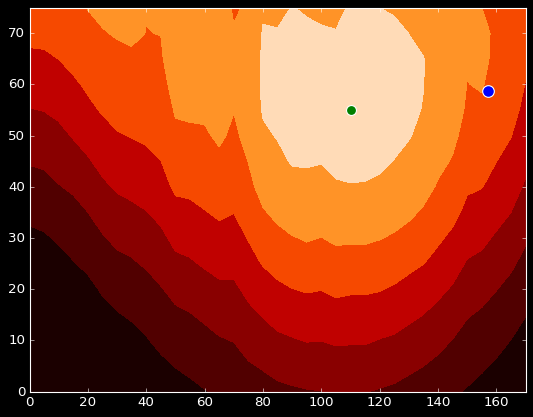

In [186]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.contourf(az_v, al_v, values, cmap=mpl.cm.gist_heat)
ax.scatter(max_az, max_al, c='green', s=80)
ax.scatter(expected_max[0], expected_max[1], c='blue', s=110)

In [147]:
# this day time parameters

initial_time = 1653059937.2305858
delta_t = 60

start_time = dtm.datetime.fromtimestamp(initial_time).replace(hour=0, minute=0, second=0).timestamp()
end_time = dtm.datetime.fromtimestamp(initial_time).replace(hour=23, minute=59, second=59).timestamp()

In [148]:
scheme = ControlScheme.get_uniform(start_time, end_time,
                                   positions=[
                                        (180, 0),
                                        (270, 45),
                                        (340, 0),
                                        (180, 0)
                                    ])

In [151]:
for corr in scheme.corrections:
    print(dtm.datetime.fromtimestamp(corr.timestamp))

2022-05-20 00:00:00.230586
2022-05-20 07:59:59.897253
2022-05-20 15:59:59.563919
2022-05-20 23:59:59.230586


In [152]:
measure_time = dtm.datetime.fromtimestamp(sun_diagram.time)
start_time = measure_time.replace(hour=0, minute=0, second=0).timestamp()
end_time = measure_time.replace(hour=23, minute=59, second=59).timestamp() + 1
delta_t = 100

In [153]:
def show_approximation(_scheme: ControlScheme, _delta_t):
    _set_time, _sunset, _rise_time, _sunrise = \
        get_sun_borders(_scheme.day_begin_time, _scheme.day_end_time, _delta_t)

    _times = np.arange(_set_time, _rise_time, _delta_t)
    _intermediate = _scheme.get_positions(_times)
    _ideal = sun_position(_times)

    _fig, _axes = plt.subplots(ncols=2)
    _fig.set_size_inches(15, 7.5)
    _axes[0].plot([_times[0], _times[-1]], [_sunset[0], _sunset[0]], c="r")
    _axes[0].plot([_times[0], _times[-1]], [_sunrise[0], _sunrise[0]], c="r")
    _axes[0].plot(_times, _intermediate[0, :])
    _axes[0].plot(_times, _ideal[0])

    _axes[1].plot([_times[0], _times[-1]], [_sunset[1], _sunset[1]], c="r")
    _axes[1].plot([_times[0], _times[-1]], [_sunrise[1], _sunrise[1]], c="r")
    _axes[1].plot(_times, _intermediate[1, :])
    _axes[1].plot(_times, _ideal[1])

    plt.show()
    print(f"energy: {integrate_control_scheme(_scheme, sun_diagram, _set_time, _rise_time)}")
    print(f"motor: {get_total_motor_consumption(_scheme)}")


In [156]:
_scheme = ControlScheme.get_uniform(start_time, end_time,
                                         [
                                            (180, 0),
                                            (270, 45),
                                            (200, 45),
                                            (180, 0),
                                            (180, 0),
                                         ])

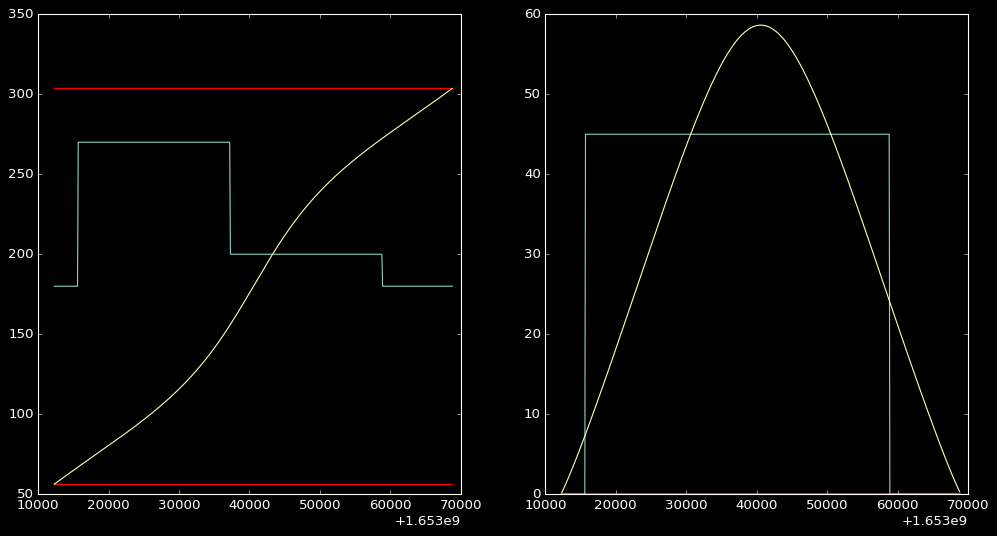

energy: 19.153571515827476
motor: 31.5


In [157]:
show_approximation(_scheme, delta_t)

In [160]:
total_power = integrate_control_scheme(_scheme, sun_diagram, start_time, end_time, 60)
total_power

19.153467538551027

In [161]:
_time = sun_diagram.time

az_v, al_v = np.meshgrid(list(sun_diagram.diagram.az_range), list(sun_diagram.diagram.al_range))
_positions = np.concatenate([np.atleast_2d(az_v.flatten()),
                             np.atleast_2d(al_v.flatten())], axis=0)

_powers = sun_diagram.get_timed_power(_time, _positions)
_powers = _powers.reshape(az_v.shape)


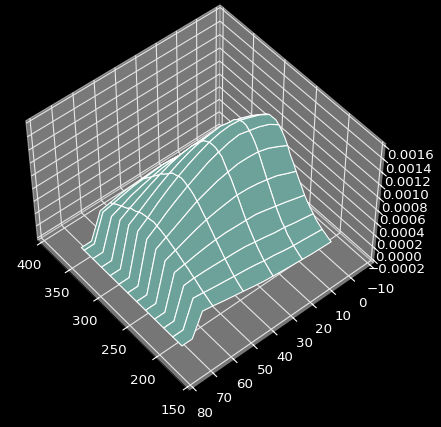

In [162]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(50, 140)
_stride = 3
ax.plot_surface(az_v, al_v, _powers, rstride=_stride, cstride=_stride)
max_pos = np.unravel_index(np.argmax(_powers, axis=None), _powers.shape)

ax.scatter(az_v[max_pos], al_v[max_pos], _powers[max_pos], c='r', s=100)

In [163]:
fig = plt.figure()
ax = fig.add_subplot(111)

_set_time, _sunset, _rise_time, _sunrise = \
    get_sun_borders(_scheme.day_begin_time, _scheme.day_end_time, delta_t)
_times = np.arange(_set_time, _rise_time, delta_t)

az_v, al_v = np.meshgrid(np.arange(0, 360, 5), np.arange(0, 90, 5))
_points = np.concatenate([np.atleast_2d(az_v.flatten()),
                          np.atleast_2d(al_v.flatten())], axis=0)

avg_power = np.empty(_points.shape[1])
_p = np.empty((2, _times.shape[0]))
for _point_i in range(_points.shape[1]):
    _p[0, :] = _points[0, _point_i]
    _p[1, :] = _points[1, _point_i]
    avg_power[_point_i] = np.average(sun_diagram.get_timed_power(_times, _p))

In [127]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.contourf(az_v, al_v, avg_power.reshape(az_v.shape), cmap=mpl.cm.gist_heat)
_ideal = sun_position(_times)
ax.plot(*_ideal, c="g", linewidth=3)